# **ANALYSIS OF CLOSED LOOP SYSTEMS**

This notebook is about the analysis of closed loop systems.

In [1]:
if False:
    !pip -q install controlSBML
    !pip -q install control
    !pip -q install tellurium

In [2]:
import control
import controlSBML as ctl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tellurium as te

# Helpers

In [3]:
s = control.TransferFunction.s
TIMES = np.linspace(0, 10, 100)

In [4]:
TEST_MODEL = """
$S1 -> S2; k1*S1
S2 -> S3; k2*S2

S1 = 10
S2 = 0
S3 = 0
k1 = 1
k2 = 2
"""
TEST_RR = te.loada(TEST_MODEL)

In [5]:
k1 = TEST_RR["k1"]
k2 = TEST_RR["k2"]
tf = k1*k2/(s*(s+k2))

In [126]:
def evaluateTransferFunction(model, transfer_function, input_name, output_name, times=TIMES,
                             is_plot=True, figsize=(5,5), title="", **kwargs):
    """
    Plots simulations versus predictions.

    Args:
        model: (str) antimony or roadrunner
        tranfer_function (control.TransferFunction)
        input_name: (str)
        output_name: (str) prediction
        times: (np.darray)
        kwargs: simultion parameters
    Returns:
        float
    """
    if isinstance(model, str):
        rr = te.loada(model)
    else:
        rr = model
    for key, value in kwargs.items():
        rr[key] = value
    rr.reset()
    data = rr.simulate(times[0], times[-1], len(times))
    new_output_name = "[" + output_name + "]"
    if new_output_name in data.colnames:
        output_name = new_output_name
    simulations = data[output_name]
    _, predictions = control.forced_response(transfer_function, T=times, U=1)
    predictions = rr[input_name]*predictions
    rmse = np.sqrt(np.sum(simulations-predictions)**2)/len(simulations)
    if is_plot:
        _, ax = plt.subplots(1, figsize=figsize)
        ax.scatter(simulations, predictions)
        maxval = max(np.max(predictions), np.max(simulations))
        ax.plot([0, maxval], [0, maxval], color="red")
        ax.set_xlabel("simulated")
        ax.set_ylabel("predicted")
        ax.set_title(title)
    return rmse

rmse = evaluateTransferFunction(TEST_MODEL, tf, "S1", "S3", k1=1, figsize=(3,3), is_plot=False)
assert(rmse < 1e-5)
print("OK!")

OK!


In [57]:
def plotModel(model, times=TIMES, is_plot=True, title="", selections=None, 
              figsize=(5,5), ylim=None, **kwargs):
    """
    Plots a model.
    
    Args:
       times: np.array 
       kwargs: values of parameters
    Returns:
       ExtendedRoadrunner
    """
    rr = te.loada(model)
    for key, value in kwargs.items():
        rr[key] = value
    if selections is None:
        rr.simulate(times[0], times[-1], len(times))
    else:
        if not "time" in selections:
            selections.insert(0, "time")
        rr.simulate(times[0], times[-1], len(times), selections=selections)
    if is_plot:
        if ylim is None:
            rr.plot(title=title, figsize=figsize)
        else:
            rr.plot(title=title, figsize=figsize, ylim=ylim)
    return rr
    
# TESTS
plotModel(TEST_MODEL, k1=0.1, is_plot=False, selections=["S2"], ylim=[0, 10])
print("OK!")

OK!


In [81]:
def makeTransferFunction(roadrunner, k_ss, k_ds, input_name):
    """
    Creates a transfer function for a sequential network based the the kinetic constants in
    are synthesis and degradation reactions.
    Args:
        roadrunner: Roadrunner (model)
        k_ss: list-str (kinetic constants in synthesis reactions)
        k_ds: list-str (kinetic constants in degradation reactions)
        input_name: str (name of input species)
    Returns:
        control.TransferFunction 
    """
    numr = np.prod([roadrunner[k] for k in k_ss])
    denom = np.prod([(s + roadrunner[k]) if isinstance(k, str) else s for k in k_ds])
    return numr/denom

# TESTS
tf = makeTransferFunction(TEST_RR, ["k1", "k2"], ["k2", 0], "S1") 
rmse = evaluateTransferFunction(TEST_MODEL, tf, "S1", "S3", is_plot=False)
assert(isinstance(tf, control.TransferFunction))
assert(rmse < 1e-3)
print("OK!")

OK!


# Transfer Function of Controllers

<img src=https://github.com/joseph-hellerstein/advanced-controls-lectures/raw/main/lectures/images/pid_control.png width="500"/>

## Proportional control

\begin{eqnarray}
u(t)& = & k_P e(t) \\
U(s) & = & k_P E(s) \\
G_P(s) & = & \frac{U(s)}{E(s)} \\
& = & k_P
\end{eqnarray}

## Integral control

\begin{eqnarray}
u(t)& = & k_I \int_0^t e(v) dv \\
U(s) & = & \frac{k_I}{s} E(s) \\
G_I(s) & = & \frac{U(s)}{E(s)} \\
& = & \frac{k_I}{s}
\end{eqnarray}

## Differential control

\begin{eqnarray}
u(t)& = & k_D \frac{d e(t)}{dt}\\
U(s) & = & k_D s E(s) \\
G_D(s) & = & \frac{U(s)}{E(s)} \\
& = & k_D s 
\end{eqnarray}

## Combinations of controllers

**PI Controller**
\begin{eqnarray}
u(t) & = & k_P e(t) + k_I \int_0^t e(t) dv \\
U(s) & = & k_P E(s) + \frac{k_I}{ s} E(s) \\
G_{PI} (s) & = & G_P (s) + G_I(s) \\
& = & k_P + \frac{k_I}{ s}  \\
& = & \frac{s k_P + k_I}{ s}  \\
\end{eqnarray}

**PID Controller**
\begin{eqnarray}
u(t) & = & k_P e(t) + k_I \int_0^t e(t) dv + k_D \frac{d e(t)}{ dt} \\
U(s) & = & k_P E(s) + \frac{k_I}{ s} E(s) + k_D s E(s) \\
G_{PID} (s) & = & G_P (s) + G_I(s) + G_D(s)\\
& =  & \frac{s^2k_D + sk_P + k_I}{ s} \\
\end{eqnarray}

## Questions
1. What are the poles and zeroes of a PI controller?
1. What are the poles and zeroes of a PID controller?
1. Which are proper transfer functions?

# P control w/o Filter

<img src=https://github.com/joseph-hellerstein/advanced-controls-lectures/raw/main/lectures/images/simple_feedback_nofilter.png/
     width="600">

### Derivation

We want the transfer function from $r(t)$ to $y(t)$. We denote this by $H(s).

We will use the following facts about transfer functions:
1. Laplace transfers are linear. So the Lapace transform of $a x(t) + b y(t)$ is $a X(s) + b Y(s)$.
1. The Laplace transfer of the concatenation of systems is the product of their Laplace transforms *if the first systems is unaffected by the degradation of its output species*.

Let $G(s)$ be the transfer function of the open loop system (OLS) and $C(s)$ be the controller transfer function.

We start with the following observations:
1. The signal $y(t)$ is the output of the system composed of the concatenation of the controller with the open loop system that has the input signal $e(t)$. That is,
$$Y(s)= E(s) C(s) G(s)$$.
1. $e(t)$ is the difference between $r(t)$ and $y(t)$. That is $E(s) = R(s) - Y(s)$.

Now, we substitute and solve.
\begin{eqnarray}
Y(s) & = & E(s) C(s) G(s) \\
    & = & (R(s) - Y(s)) C(s) G(s) \\
Y(s) + Y(s) C(s) G(s) & = & R(s) C(s) G(s) \\
Y(s) & = & \frac{R(s) C(s) G(s)}{1 + C(s) G(s)} \\
H(s) & = & \frac{ C(s) G(s)}{1 + C(s) G(s)} \\
\end{eqnarray}

### Verification

#### Step 1: Antimony model of the closed loop system

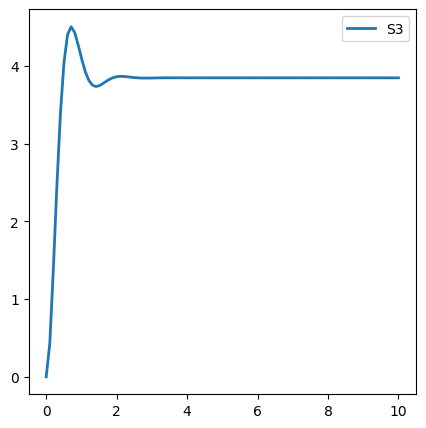

In [84]:
MODEL1 = """
S1 -> S2; k1*S1
S2 -> S3; k2*S2
S3 -> ; k3*S3

S2 = 0
k1 =1
k2 = 2
k3 = 3
// ***** Feedback
setpoint = 1  # Input to the closed loop is the setpoint or reference
kP = 1  # Design parameter for P controller
kI = 0 # Design parameter for integral control
control_error := setpoint - S3
$S1 := kP*control_error   # Controller implementation
"""
rr =plotModel(MODEL1, setpoint=5, kP=10, selections=["S3"])
# Assign the constants used in the open and closed loops
k1 = rr["k1"]
k2 = rr["k2"]
k3 = rr["k3"]
kP = rr["kP"]
setpoint = rr["setpoint"]

#### Step 2: Derive the open loop transfer function

Transfer function $G(s)$. The long way to do it.
\begin{eqnarray}
s S_2(s) & = & k_1 S_1(s) - k_2 S_2(s) \\
S_2 (s) & = & \frac{k_1 S_1 (s)}{s + k_2} \\
s S_3 (s) &  = & k_2 S_2(s) - k_3 S_3(s) \\
S_3 (s) & = & \frac{k_2 S_2 (s)}{s + k_3} \\
G(s) & = &  \frac{k_1 k_2 }{(s + k_2)(s + k_3)} \\
\end{eqnarray}

Short cut for a deriving the transfer function of a sequential network.
1. The poles relate to degradation reactions. This excludes the input since it is a boundary species. In the example, this makes the denominator
$(s + k_2)(s + k_3)$. If there is no degradation reaction for a non-boundary species, then we have the term $(s + 0)$.
1. The numerator is the product of the kinetic constants that synthesize the output from the input. Since this is a sequential path, there is only one such product. In the example,
$k_1 k_2$.

In [85]:
# Construct the transfer function object for the open loop system
C_tf = kP
G_tf = k1*k2/( (s + k2)*(s + k3))
G_tf

TransferFunction(array([2.]), array([1., 5., 6.]))

#### Step 3: Derive the closed loop transfer function

$H(s) = \frac{ C(s) G(s)}{1 + C(s) G(s)}$

In [86]:
# Transfer function object for the closed loop system
H_tf = C_tf*G_tf/(1 + C_tf*G_tf)
H_tf

TransferFunction(array([ 20., 100., 120.]), array([  1.,  10.,  57., 160., 156.]))

In [87]:
# Actually, this is much more complicated than necessary. Look at the pole/zero cancellations.
H_tf.poles(), H_tf.zeros()

(array([-2.5+4.44409721j, -2.5-4.44409721j, -3. +0.j        ,
        -2. +0.j        ]),
 array([-3.+0.j, -2.+0.j]))

In [88]:
# You can get a simplified transfer function using the feedback method.
H_tf = control.feedback(C_tf*G_tf)
H_tf

TransferFunction(array([20.]), array([ 1.,  5., 26.]))

In [89]:
H_tf.poles(), H_tf.zeros()

(array([-2.5+4.44409721j, -2.5-4.44409721j]), array([], dtype=complex128))

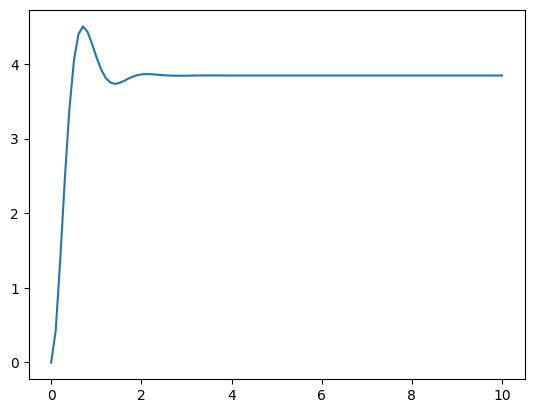

In [90]:
# Plot the transfer function
_, predictions = control.forced_response(H_tf, T=TIMES, U=1)
plt.plot(TIMES, setpoint*predictions)

In [91]:
H_tf.poles(), H_tf.zeros()

(array([-2.5+4.44409721j, -2.5-4.44409721j]), array([], dtype=complex128))

#### Step 4: Compare the simulation and the transfer function

1.2023549800697209

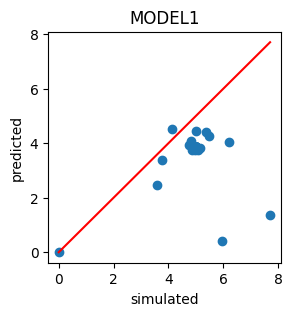

In [92]:
evaluateTransferFunction(MODEL1, H_tf, "setpoint", "S3", setpoint=5, kP=1000,
                        figsize=(3,3), title="MODEL1")

### Effect of kP

1. What are the poles of $H(s)$ for $kP \in \{ 1, 5, 50 \}$?

We use the "short cut" to obtain the transfer function for the open loop system.
1. The synthesis reactions have the kinetic constants $k_1, k_2$.
1. Degradation reactions have the kinetic constants $k_2, $k_3$.

$$G(s) = \frac{k_1 k_2}{(s + k_2)(s +k_3)}$$

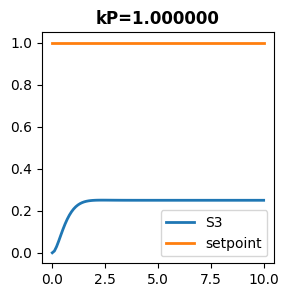

[-2.5+1.32287566j -2.5-1.32287566j -3. +0.j         -2. +0.j        ]


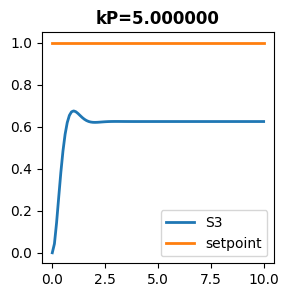

[-2.5+3.122499j -2.5-3.122499j -3. +0.j       -2. +0.j      ]


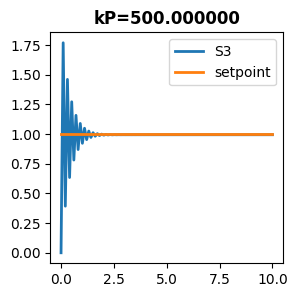

[-2.5+31.61882351j -2.5-31.61882351j -3.  +0.j         -2.  +0.j        ]


In [93]:
kPs = [1, 5, 500]
for kP in kPs:
    rr = plotModel(MODEL1, kP=kP, selections=["S3", "setpoint"], figsize=(3,3), title="kP=%f" % kP)
    ols_tf = makeTransferFunction(rr, ["k1", "k2"], ["k2", "k3"], "S1")
    cl_tf = kP*ols_tf/(1 + kP*ols_tf)
    print(cl_tf.poles()) 

# PI Control w/o Filter

## Step 1: Antimony model of the closed loop system

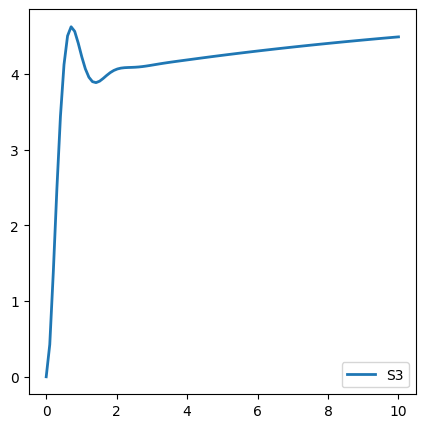

In [113]:
MODEL2 = """
S1 -> S2; k1*S1
S2 -> S3; k2*S2
S3 -> ; k3*S3

S2 = 0
k1 =1
k2 = 2
k3 = 3
// ***** Feedback
setpoint = 1  # Input to the closed loop is the setpoint or reference
kP = 1  # Design parameter for P controller
kI = 0 # Design parameter for integral control
control_error := setpoint - S3
integral_control_error = 0
integral_control_error' = control_error
$S1 := kP*control_error + kI*integral_control_error  # Controller implementation
"""
rr =plotModel(MODEL2, setpoint=5, kP=10, kI=1, selections=["S3"])
# Assign the constants used in the open and closed loops
k1 = rr["k1"]
k2 = rr["k2"]
k3 = rr["k3"]
kP = rr["kP"]
kI = rr["kI"]
setpoint = rr["setpoint"]

## Step 2: Derive the open lop transfer function

The same open loop system as before.

In [114]:
G_tf = k1*k2/( (s + k2)*(s + k3))

## Step 3: Derive the closed loop transfer function

In [115]:
# Transfer function object for the closed loop system
C_tf = kP + kI/s
H_tf = C_tf*G_tf/(1 + C_tf*G_tf)
H_tf

TransferFunction(array([ 20., 102., 130.,  12.,   0.]), array([  1.,  10.,  57., 162., 166.,  12.,   0.]))

In [116]:
H_tf = control.feedback(C_tf*G_tf)
H_tf

TransferFunction(array([20.,  2.]), array([ 1.,  5., 26.,  2.]))

How do we check if these transfer functions are the same?

## Step 4: Compare the simulation and the transfer function

In [131]:
def makeCLTransferFunction(rr):
    # Initialize parameters from the roadrunner
    k1 = rr["k1"]
    k2 = rr["k2"]
    k3 = rr["k3"]
    setpoint = rr["setpoint"]
    kI = rr["kI"]
    kP = rr["kP"]
    # Create the transfer functions for the roadrunner
    G_tf = k1*k2/( (s + k2)*(s + k3))
    C_tf = kP + kI/s
    H_tf = C_tf*G_tf/(1 + C_tf*G_tf)
    #
    return H_tf

3.417846111464229e-08

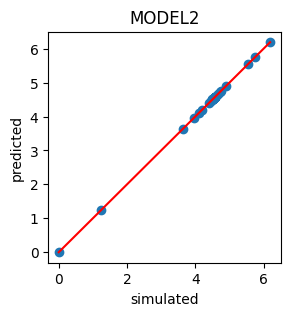

In [133]:
rr =plotModel(MODEL2, setpoint=5, kP=30, kI=0.001, selections=["S3"], is_plot=False)
H_tf = makeCLTransferFunction(rr)
evaluateTransferFunction(rr, H_tf, "setpoint", "S3",
                        figsize=(3,3), title="MODEL2")

## Effect of Kp, kI

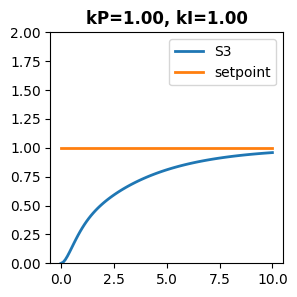

[-3.        +0.j         -2.34781038+1.02885225j -2.34781038-1.02885225j
 -2.        +0.j         -0.30437923+0.j          0.        +0.j        ]


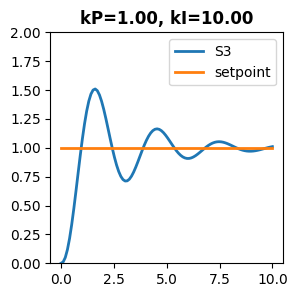

[-0.38661381+2.14062435j -0.38661381-2.14062435j -4.22677238+0.j
 -3.        +0.j         -2.        +0.j          0.        +0.j        ]


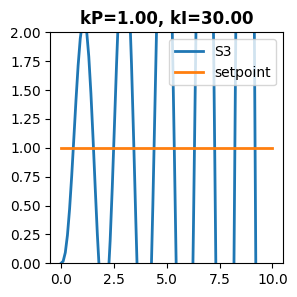

[-5.51989577+0.j          0.25994789+3.28666968j  0.25994789-3.28666968j
 -3.        +0.j         -2.        +0.j          0.        +0.j        ]


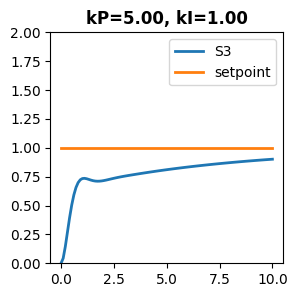

[-2.43492193+3.07202134j -2.43492193-3.07202134j -3.        +0.j
 -2.        +0.j         -0.13015614+0.j          0.        +0.j        ]


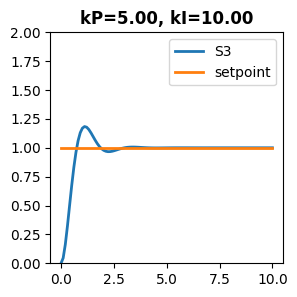

[-1.5       +2.78388218j -1.5       -2.78388218j -3.        +0.j
 -2.00000013+0.j         -1.99999987+0.j          0.        +0.j        ]


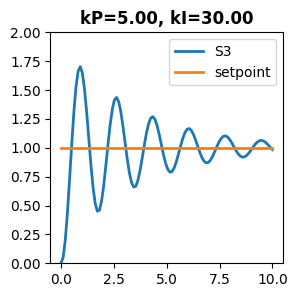

[-0.28000625+3.66539876j -0.28000625-3.66539876j -4.43998751+0.j
 -3.        +0.j         -2.        +0.j          0.        +0.j        ]


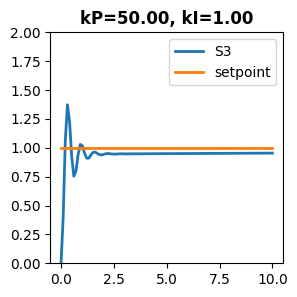

[-2.49055766+9.98514175j -2.49055766-9.98514175j -3.        +0.j
 -2.        +0.j         -0.01888468+0.j          0.        +0.j        ]


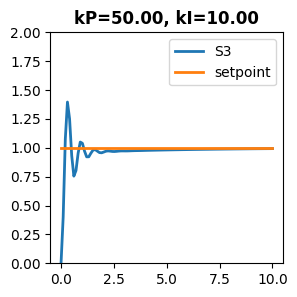

[-2.40483859+9.96500677j -2.40483859-9.96500677j -3.        +0.j
 -2.        +0.j         -0.19032283+0.j          0.        +0.j        ]


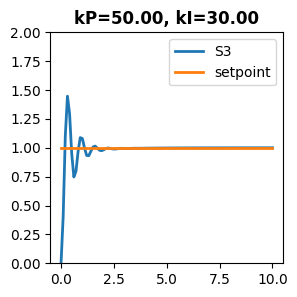

[-2.20996597+9.92734552j -2.20996597-9.92734552j -3.        +0.j
 -2.        +0.j         -0.58006806+0.j          0.        +0.j        ]


In [138]:
kPs = [1, 5, 50]
kIs = [1, 10, 30]
for kP in kPs:
    for kI in kIs:
        rr = plotModel(MODEL2, kP=kP, kI=kI, selections=["S3", "setpoint"], figsize=(3,3), 
                       title="kP=%2.2f, kI=%2.2f" % (kP, kI), ylim=[0, 2])
        H_tf = makeCLTransferFunction(rr)
        print(H_tf.poles()) 

# PI with filter

<img src=https://github.com/joseph-hellerstein/advanced-controls-lectures/raw/main/lectures/images/simple_closed_loop.png/
     width="600">